In [1]:
import os
import pandas as pd
import numpy as np

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [2]:
def group_f1_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    try: 
        score = metrics.roc_auc_score(label, pred)
    except: 
        score = np.nan
    return score

In [3]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    # pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    # pred_b = softmax(pred_b)
    # return pred_b[1] # the probability to greater label
    return pred[2]+pred[3]

In [4]:
def convert2cls(chir, csp_category): 
    if csp_category == '1' or csp_category == 1: 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2' or csp_category == 2: 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## 1. Load prediction results

In [5]:
dfs = []
for mb in range(18): 
    dfs.append(pd.read_csv('../results0804/molnet_cmrt_cls_etkdg_csp{}.csv'.format(str(mb)), 
                               sep='\t', index_col=0))
df_pred = pd.concat(dfs, ignore_index=True)
    
dfs_ena = []
for mb in range(18): 
    dfs_ena.append(pd.read_csv('../results0804/molnet_cmrt_cls_etkdg_csp{}-ena.csv'.format(str(mb)), 
                               sep='\t', index_col=0))
df_pred_ena = pd.concat(dfs_ena, ignore_index=True)

df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)
df_pred_ena['Pred_b'] = df_pred_ena['Pred'].apply(binary_pred)

df_pred = df_pred.merge(df_pred_ena[['Pred_b']], left_index=True, right_index=True)

df_pred['Pred_b'] = df_pred.apply(lambda x: (x['Pred_b_x'] + x['Pred_b_y']) / 2, axis=1)

In [6]:
df_pred = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [7]:
df_pred

,SMILES,MB,Pred,Pred_b_x,Pred_b_y,Pred_b
0,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0,"2.1838619431946427e-05,0.9998779296875,7.47728...",0.000100,0.005627,0.002864
1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,0,"0.0003162250213790685,0.26155582070350647,0.73...",0.738128,0.961667,0.849897
2,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,0,"0.9112429022789001,0.03946007415652275,0.04927...",0.049297,0.036640,0.042969
3,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,0,"0.014791402965784073,0.8652480840682983,0.1197...",0.119960,0.282131,0.201046
4,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,"3.9730293792672455e-05,0.9998822212219238,6.67...",0.000078,0.000026,0.000052
...,...,...,...,...,...,...
97303,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,17,"0.011014926247298717,3.5176901292288676e-05,0....",0.988950,0.996447,0.992698
97304,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,17,"0.00010181145626120269,5.340492134564556e-05,0...",0.999845,0.999876,0.999861
97305,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,17,"0.00011382971570128575,3.3167205401696265e-05,...",0.999853,0.999807,0.999830
97306,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,17,"0.00526067242026329,0.00015392563364002854,0.9...",0.994586,0.427147,0.710866


## 2. Load CMRT

In [8]:
suppl = Chem.SDMolSupplier("../data/CMRT/cmrt_clean.sdf")
mols = [x for x in suppl if x is not None]

In [9]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [10]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [11]:
df_label

,SMILES,MB,K2/K1,Y
0,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
2,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,16,0.3095,0
3,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,16,0.3095,0
4,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,2.7838,3
...,...,...,...,...
5401,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,6,1.0833,1
5402,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,16,1.2459,2
5403,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,16,1.2459,2
5404,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,16,1.1218,0


## 3. Merge

In [12]:
df_csp = pd.read_csv('../preprocess/chirality_stationary_phase_list.csv').dropna()

Convert isomer SMILES into regular SMILES

In [13]:
df_pred['SMILES_iso'] = df_pred['SMILES']
df_label['SMILES_iso'] = df_label['SMILES']

df_pred['SMILES'] = df_pred['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_label['SMILES'] = df_label['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [14]:
df_pred['MB'] = df_pred['MB'].astype(int)
df_label['MB'] = df_label['MB'].astype(int)

df_cmrt = df_pred.merge(df_label, on=['SMILES_iso', 'SMILES', 'MB'], how='right').dropna()
df_cmrt['Y_b'] = df_cmrt['Y'].apply(binary_cls)

df_cmrt0 = df_cmrt[df_cmrt['Y_b'] == 0]
df_cmrt1 = df_cmrt[df_cmrt['Y_b'] == 1]

df_cmrt0 = df_cmrt0.sort_values(['SMILES', 
                                 'MB', 
                                 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 
                                                                              'MB'], keep='last').sort_index()

df_cmrt1 = df_cmrt1.sort_values(['SMILES', 
                                 'MB', 
                                 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 
                                                                              'MB'], keep='first').sort_index()

df_cmrt = pd.concat([df_cmrt0, df_cmrt1])

In [15]:
df_cmrt

,SMILES,MB,Pred,Pred_b_x,Pred_b_y,Pred_b,SMILES_iso,K2/K1,Y,Y_b
0,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,16,"0.9930918216705322,4.6633202146040276e-05,0.00...",6.861529e-03,9.533887e-01,4.801251e-01,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0.7792,0,0
2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,16,"0.9999861717224121,1.573329427628778e-06,1.219...",1.223316e-05,2.045047e-05,1.634182e-05,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,0.3095,0,0
25,CC(CS(C)(=O)=O)c1ccccc1,14,"0.9999996423721313,5.218329235390229e-08,1.921...",2.033562e-07,2.924865e-07,2.479214e-07,C[C@@H](CS(C)(=O)=O)c1ccccc1,1.1754,1,0
41,CC(C#N)c1cccc2ccccc12,9,"0.0003394424566067755,0.0004004818038083613,0....",9.992600e-01,9.992599e-01,9.992599e-01,C[C@H](C#N)c1cccc2ccccc12,1.1343,1,0
86,C#CC(C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,8,"0.0007122305687516928,0.0007909350097179413,0....",9.984967e-01,9.985117e-01,9.985042e-01,C#C[C@H](C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,1.1170,1,0
...,...,...,...,...,...,...,...,...,...,...
5187,COc1ccc(C(C=CC(=O)n2nc(C)c(C)c2C)N(C)Cc2ccccc2...,16,"2.319035047548823e-05,3.7134614103706554e-06,0...",9.999731e-01,9.998946e-01,9.999339e-01,COc1ccc([C@@H](/C=C/C(=O)n2nc(C)c(C)c2C)N(C)Cc...,1.3895,2,1
5189,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)CC1C(F)(F)F,0,"0.0014535614755004644,0.0028940499760210514,0....",9.956523e-01,9.467876e-01,9.712200e-01,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)C[C@@H]1C(F)(F)F,1.5388,2,1
5192,CC1=NN(c2ccccc2)C(=O)C1(CC=Cc1ccccc1)Cc1ccccc1,16,"3.418363576201955e-06,1.2499608601501677e-05,0...",9.999840e-01,9.999735e-01,9.999788e-01,CC1=NN(c2ccccc2)C(=O)[C@@]1(C/C=C/c1ccccc1)Cc1...,1.4980,2,1
5200,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,"2.5604223992559128e-05,2.1233024938283052e-07,...",9.999742e-01,9.999914e-01,9.999828e-01,C[C@@]1(Nc2ccccc2I)C(=O)Nc2ccccc21,1.4901,2,1


Exclude the overlapped samples between ChirBase and CMRT

In [16]:
df_overlap = pd.read_csv('../data/compare_chirbase_cmrt.csv')

df_overlap = df_overlap.sort_values(['SMILES', 'Column_x', 'K2/K1_x'], 
                              ascending=False).drop_duplicates(['SMILES', 'Column_x'], 
                                                               keep='first').sort_index()
df_overlap = df_overlap.merge(df_csp, left_on='Column_x', right_on='Short_Name', how='left')

df_nonoverlap = pd.merge(df_cmrt, df_overlap, 
                         left_on=['SMILES', 'MB'], right_on=['SMILES', 'CSP_Encode'], 
                         how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [17]:
df_nonoverlap

,SMILES,MB,Pred,Pred_b_x,Pred_b_y,Pred_b,SMILES_iso,K2/K1,Y,Y_b,...,CSP_category,Y_x,Y_y,Y_x2,Y_y2,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,16,"0.9930918216705322,4.6633202146040276e-05,0.00...",6.861529e-03,9.533887e-01,4.801251e-01,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0.7792,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,16,"0.9999861717224121,1.573329427628778e-06,1.219...",1.223316e-05,2.045047e-05,1.634182e-05,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,0.3095,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC(CS(C)(=O)=O)c1ccccc1,14,"0.9999996423721313,5.218329235390229e-08,1.921...",2.033562e-07,2.924865e-07,2.479214e-07,C[C@@H](CS(C)(=O)=O)c1ccccc1,1.1754,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC(C#N)c1cccc2ccccc12,9,"0.0003394424566067755,0.0004004818038083613,0....",9.992600e-01,9.992599e-01,9.992599e-01,C[C@H](C#N)c1cccc2ccccc12,1.1343,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C#CC(C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,8,"0.0007122305687516928,0.0007909350097179413,0....",9.984967e-01,9.985117e-01,9.985042e-01,C#C[C@H](C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,1.1170,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,COc1ccc(C(C=CC(=O)n2nc(C)c(C)c2C)N(C)Cc2ccccc2...,16,"2.319035047548823e-05,3.7134614103706554e-06,0...",9.999731e-01,9.998946e-01,9.999339e-01,COc1ccc([C@@H](/C=C/C(=O)n2nc(C)c(C)c2C)N(C)Cc...,1.3895,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2442,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)CC1C(F)(F)F,0,"0.0014535614755004644,0.0028940499760210514,0....",9.956523e-01,9.467876e-01,9.712200e-01,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)C[C@@H]1C(F)(F)F,1.5388,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2443,CC1=NN(c2ccccc2)C(=O)C1(CC=Cc1ccccc1)Cc1ccccc1,16,"3.418363576201955e-06,1.2499608601501677e-05,0...",9.999840e-01,9.999735e-01,9.999788e-01,CC1=NN(c2ccccc2)C(=O)[C@@]1(C/C=C/c1ccccc1)Cc1...,1.4980,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2444,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,"2.5604223992559128e-05,2.1233024938283052e-07,...",9.999742e-01,9.999914e-01,9.999828e-01,C[C@@]1(Nc2ccccc2I)C(=O)Nc2ccccc21,1.4901,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate metrics (AUC, ACC, KAPPA, F1, COUNT)

In [18]:
df_nonoverlap['Class_b'] = df_nonoverlap['Y'].apply(binary_cls)

In [19]:
auc = df_nonoverlap.groupby('MB').apply(group_auc_b)
acc = df_nonoverlap.groupby('MB').apply(group_acc_b)
kappa = df_nonoverlap.groupby('MB').apply(group_kappa_b)
f1 = df_nonoverlap.groupby('MB').apply(group_f1_b)
cnt = df_nonoverlap.groupby('MB').size()

In [20]:
df_res_all = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_all.reset_index(inplace=True)
df_res_all = df_res_all.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_all = df_res_all.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [21]:
df_res_all

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,0,0.526027,0.735915,0.064641,0.735915,284,Chiralpak IB,IB,91423,0,2
1,6,0.692130,0.835052,0.369618,0.835052,97,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
2,8,0.723958,0.791139,0.237942,0.791139,158,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
3,9,0.604357,0.690647,0.294083,0.690647,139,Chiralpak AS,AS,45167,9,2
4,11,0.683312,0.823045,0.274929,0.823045,243,Chiralpak AD,AD,23735,11,2
5,14,0.616285,0.620899,0.172736,0.620899,823,Chiralpak IC (Sepapak 5),IC,91518,14,1
6,16,0.628639,0.623932,0.153738,0.623932,702,Chiralpak IA,IA,45172,16,1


In [22]:
# with pd.ExcelWriter('test_cmrt.xlsx') as writer:  
#     df_res_all.to_excel(writer, sheet_name='all')
#     df_res_overlap.to_excel(writer, sheet_name='overlap')

## 4. Load the results of cross-validation on ChirBase

In [23]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results0804/molnet_chirality_cls_etkdg_csp{}-5fold_tl_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
df_chirbase = pd.concat(dfs, ignore_index=True)

df_chirbase['Class_b'] = df_chirbase['Class'].apply(binary_cls)
df_chirbase['Pred_b'] = df_chirbase['Pred'].apply(binary_pred)

In [24]:
auc = df_chirbase.groupby('MB').apply(group_auc_b)
acc = df_chirbase.groupby('MB').apply(group_acc_b)
kappa = df_chirbase.groupby('MB').apply(group_kappa_b)
f1 = df_chirbase.groupby('MB').apply(group_f1_b)
cnt = df_chirbase.groupby('MB').size()

In [25]:
df_res_cv = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_cv.reset_index(inplace=True)
df_res_cv = df_res_cv.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_cv = df_res_cv.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [26]:
df_res_cv

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,0,0.947577,0.924060,0.820114,0.924060,1330,Chiralpak IB,IB,91423,0,2
1,6,0.683776,0.826627,0.461611,0.826627,8300,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
2,8,0.844038,0.913925,0.741619,0.913925,27360,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
3,9,0.842391,0.912971,0.723982,0.912971,7170,Chiralpak AS,AS,45167,9,2
4,11,0.832335,0.901336,0.715342,0.901336,21700,Chiralpak AD,AD,23735,11,2
5,14,0.830561,0.864039,0.673767,0.864039,2030,Chiralpak IC (Sepapak 5),IC,91518,14,1
6,16,0.854548,0.850746,0.667058,0.850746,2680,Chiralpak IA,IA,45172,16,1


### Plot!!

In [27]:
def plot_roc_curve_b(pred, target, name=None, save_fig=False, print_confusion_metrics=False): 
    f, ax = plt.subplots(figsize=(6, 6))

    fpr, tpr, thresh = metrics.roc_curve(target, pred)
    auc = metrics.roc_auc_score(target, pred)
    ax.plot(fpr, tpr, label="super-class 1 vs the rest (AUC={:.2f})".format(auc))

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("CSP {}".format(name))
    ax.legend()

    if save_fig: 
        plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
        print('Save!')
    plt.show()
    
    # confusion metrics
    if print_confusion_metrics: 
        pred = np.argmax(pred_prob, axis=1)
        print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
        print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

In [28]:
# plot_roc_curve_b(df_cmrt['Pred_b'], df_cmrt['Class_b'], name='All')

In [29]:
# grouped = df_cmrt.groupby('MB')

# for name, group in grouped: 
#     print(len(group), len(group[group['Class_b']==1]))
#     plot_roc_curve_b(group['Pred_b'], group['Class_b'], name)

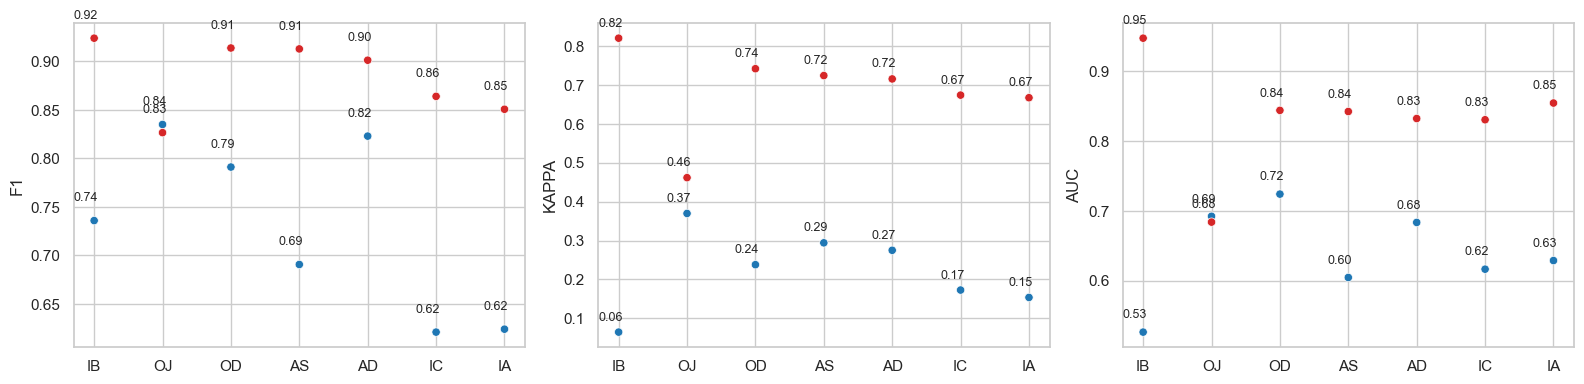

In [61]:
CSP_dict = {'IB': 0, 'OJ': 1, 'OD': 2, 'AS': 3, 'AD': 4, 'IC': 5, 'IA': 6}
# CSP_dict = {'OD': 0, 'AS': 1, 'AD': 2, 'IC': 3, 'IA': 4}
# IB: do not have overlap
# OJ: only have one positive sample
# OD: no positive samples

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

df_res_all['Label'] = 'Test on CMRT'
df_res_cv['Label'] = 'Cross validation on ChirBase'
df_res = pd.concat([df_res_all, df_res_cv])
df_res_plot = df_res[df_res['Short_Name'].isin(CSP_dict.keys())]

sns.scatterplot(data=df_res_plot, x="Short_Name", y="AUC", hue='Label', 
                ax=axs[2], legend=False, palette=['tab:blue', 'tab:red'])
axs[2].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="KAPPA", hue='Label', 
                ax=axs[1], legend=False, palette=['tab:blue', 'tab:red'])
axs[1].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="F1", hue='Label', 
                ax=axs[0], legend=False, palette=['tab:blue', 'tab:red'])
axs[0].set(xlabel=None)


for i, point in df_res_plot.iterrows(): 
    axs[2].text(CSP_dict[point['Short_Name']]-0.3, point['AUC']+0.02, '{:.2f}'.format(point['AUC']), fontsize=9)
    axs[1].text(CSP_dict[point['Short_Name']]-0.3, point['KAPPA']+0.03, '{:.2f}'.format(point['KAPPA']), fontsize=9)
    axs[0].text(CSP_dict[point['Short_Name']]-0.3, point['F1']+0.02, '{:.2f}'.format(point['F1']), fontsize=9)
    
fig.tight_layout()
plt.savefig('./test_cmrt_all.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./test_cmrt_all.png', dpi=600, bbox_inches='tight')
plt.show()

## 5. Compare with qGeoGNN

In [31]:
dfs = []
qgeognn_res_path = '/home/yuhhong/qGeoGNN_rt/results/'
files_list = [f for f in os.listdir(qgeognn_res_path) if not f.endswith('_post.csv')]

for f in files_list:
    df_tmp = pd.read_csv(os.path.join(qgeognn_res_path, f), sep='\t', index_col=0)
    df_tmp['Column'] = f.replace('.csv', '')
    dfs.append(df_tmp)

df_qgeognn = pd.concat(dfs)

df_qgeognn = df_qgeognn[['SMILES', 'Column', 'Y_Pred']]

In [32]:
data_dfs = []
for csp in ['ADH', 'ODH', 'OJ', 'OD', 'AS', 'AD', 'IA', 'IC']:
    df_tmp = pd.read_csv('/home/yuhhong/qGeoGNN_rt/dataset/{}_charity_0823.csv'.format(csp), index_col=0)
    data_dfs.append(df_tmp)
    
df_qgeognn_data = pd.concat(data_dfs)

df_qgeognn_data = df_qgeognn_data.drop(['Unnamed: 0'], axis=1)

df_qgeognn_data = df_qgeognn_data[['index', 'SMILES', 'RT', 'Speed', 'Column']]

In [33]:
df_qgeognn = df_qgeognn.merge(df_qgeognn_data, on=['SMILES', 'Column'], how='left')

In [34]:
grouped = df_qgeognn.groupby(by=['index', 'Column'])
df1 = grouped.filter(lambda x: len(x) == 1)
df2 = grouped.filter(lambda x: len(x) > 1)

Half predicted & half labeled 

In [35]:
df1 = df_qgeognn_data[df_qgeognn_data['index'].isin(df1['index'])].merge(df1, on=['index', 'Column'], how='right')

df1 = df1[df1['SMILES_x'] != df1['SMILES_y']]

df1['RT_Pred'] = df1.apply(lambda x: x['Y_Pred']/x['Speed_y'], axis=1)

df1 = df1[(df1['RT_x'] != 0) & (df1['RT_y'] != 0) & (df1['RT_Pred'] != 0)]

df1['K2/K1'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_y']) - 2.9) / (min(x['RT_x'], x['RT_y']) - 2.9), axis=1)
df1['K2/K1_Pred'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_Pred']) - 2.9) / (min(x['RT_x'], x['RT_Pred']) - 2.9), axis=1)

In [36]:
df1 = df1.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
df1['Pred_qgeognn'] = df1.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df1['Pred_qgeognn_b'] = df1['Pred_qgeognn'].apply(binary_cls)

df1.reset_index(drop=True, inplace=True)

In [37]:
df1['SMILES'] = df1['SMILES_x'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [38]:
df1 = df1.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [39]:
len(df1)

248

qGeoGNN
F1: 0.6209677419354839
KAPPA: 0.2003293084522504
ACC: 0.6209677419354839

positive: 66%, negative: 33%


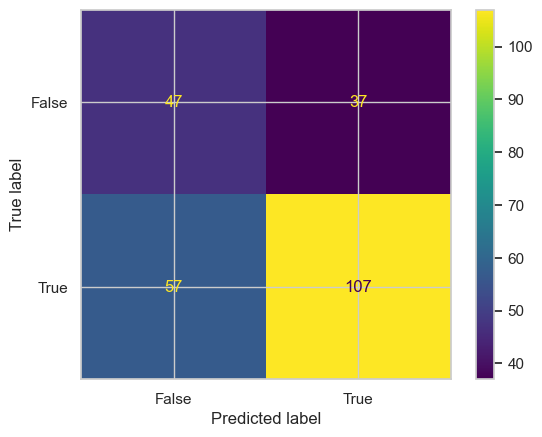

In [40]:
f1 = metrics.f1_score(df1['Y_b'], df1['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df1['Y_b'], df1['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df1['Y_b'], df1['Pred_qgeognn_b'])

print('qGeoGNN')
print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df1['Class_b'], df1['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], df1['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.5)
F1: 0.6733870967741935
KAPPA: 0.1936416184971097
AUC:0.5807200929152149
ACC: 0.6733870967741935

positive: 66%, negative: 33%


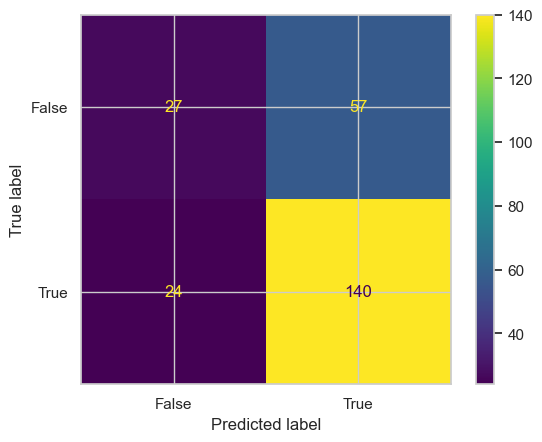

In [41]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)
    
f1 = metrics.f1_score(pred, df1['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Y_b'])
auc = metrics.roc_auc_score(df1['Y_b'], df1['Pred_b'])
acc = metrics.accuracy_score(pred, df1['Y_b'])

print('3DMolCSP (thr=0.5)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.73)
F1: 0.6733870967741935
KAPPA: 0.22833435771358324
AUC:0.5807200929152149
ACC: 0.6733870967741935

positive: 66%, negative: 33%


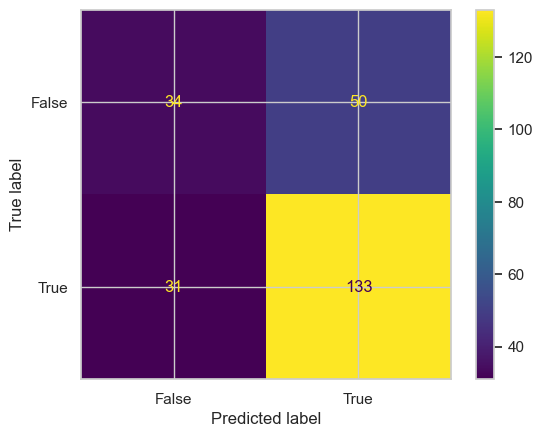

In [42]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.73, 1, 0)

f1 = metrics.f1_score(pred, df1['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Y_b'])
auc = metrics.roc_auc_score(df1['Y_b'], df1['Pred_b'])
acc = metrics.accuracy_score(pred, df1['Y_b'])

print('3DMolCSP (thr=0.73)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.9)
F1: 0.6814516129032258
KAPPA: 0.2519853390348198
AUC:0.5807200929152149
ACC: 0.6814516129032258

positive: 66%, negative: 33%


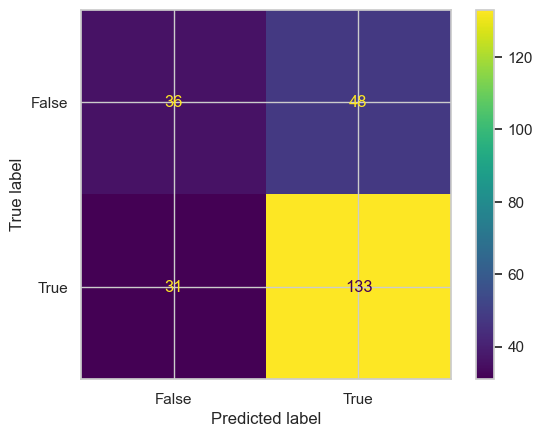

In [43]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)

f1 = metrics.f1_score(pred, df1['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Y_b'])
auc = metrics.roc_auc_score(df1['Y_b'], df1['Pred_b'])
acc = metrics.accuracy_score(pred, df1['Y_b'])

print('3DMolCSP (thr=0.9)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Totally predicted

In [44]:
df2['RT_Pred'] = df2.apply(lambda x: x['Y_Pred'] / x['Speed'], axis=1)

df_alpha = df2.groupby('index').apply(lambda x: (x['RT'].max() - 2.9) / (x['RT'].min() -2.9)).to_frame(name='K2/K1')
df_alpha_pred = df2.groupby('index').apply(lambda x: (x['RT_Pred'].max() - 2.9) / (x['RT_Pred'].min() -2.9)).to_frame(name='K2/K1_Pred')

df2 = df_alpha.merge(df2, on='index', how='left')
df2 = df2.merge(df_alpha_pred, on='index', how='left')

In [45]:
df2 = df2.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
# df2['Y'] = df2.apply(lambda x: convert2cls(x['K2/K1'], x['CSP_Category']), axis=1)
# df2['Y_b'] = df2['Y'].apply(binary_cls)
df2['Pred_qgeognn'] = df2.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df2['Pred_qgeognn_b'] = df2['Pred_qgeognn'].apply(binary_cls)

df2.reset_index(drop=True, inplace=True)

In [46]:
df2['SMILES'] = df2['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [47]:
df2

,index,K2/K1,SMILES,Column,Y_Pred,RT,Speed,RT_Pred,K2/K1_Pred,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Pred_qgeognn,Pred_qgeognn_b
0,387,1.958333,CCCCCCC(OC(=O)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(...,IC,5.510168,5.300,1.0,5.510168,2.177990,Chiralpak IC (Sepapak 5),IC,91518.0,14.0,1.0,3,1
1,387,1.958333,CCCCCCC(OC(=O)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(...,IC,8.584920,7.600,1.0,8.584920,2.177990,Chiralpak IC (Sepapak 5),IC,91518.0,14.0,1.0,3,1
2,396,1.151579,CC(=CC1CC(c2ccccc2)(c2ccccc2)CN1C(=S)Nc1ccc(C(...,IA,8.270082,8.370,1.0,8.270082,1.185619,Chiralpak IA,IA,45172.0,16.0,1.0,1,0
3,396,1.151579,CC(=CC1CC(c2ccccc2)(c2ccccc2)CN1C(=S)Nc1ccc(C(...,IA,7.429348,7.650,1.0,7.429348,1.185619,Chiralpak IA,IA,45172.0,16.0,1.0,1,0
4,485,1.220339,CC(=CC1CC(c2ccccc2)(c2ccccc2)CN1C(=S)Nc1ccc(C(...,IA,8.270082,9.380,1.0,8.270082,1.185619,Chiralpak IA,IA,45172.0,16.0,1.0,1,0
5,485,1.220339,CC(=CC1CC(c2ccccc2)(c2ccccc2)CN1C(=S)Nc1ccc(C(...,IA,7.429348,8.210,1.0,7.429348,1.185619,Chiralpak IA,IA,45172.0,16.0,1.0,1,0
6,6767,1.533333,O=S1(=O)NC(C2CCCCC2)C=C(C=Cc2ccccc2)c2ccccc21,AD,34.709103,23.600,1.5,23.139402,1.698534,Chiralpak AD,AD,23735.0,11.0,2.0,2,1
7,6767,1.533333,O=S1(=O)NC(C2CCCCC2)C=C(C=Cc2ccccc2)c2ccccc21,AD,22.223713,16.400,1.5,14.815809,1.698534,Chiralpak AD,AD,23735.0,11.0,2.0,2,1
8,7962,1.153846,CC1(Cc2ccccc2)COc2cc(C(=O)N3CCCCC3)ccc21,IA,15.787141,19.800,0.8,19.733926,1.000611,Chiralpak IA,IA,45172.0,16.0,1.0,0,0
9,7962,1.153846,CC1(Cc2ccccc2)COc2cc(C(=O)N3CCCCC3)ccc21,IA,15.795367,22.400,0.8,19.744209,1.000611,Chiralpak IA,IA,45172.0,16.0,1.0,0,0


In [48]:
df2 = df2.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [49]:
len(df2)

16

qGeoGNN
F1: 0.75
KAPPA: 0.5
ACC: 0.75

positive: 75%, negative: 25%


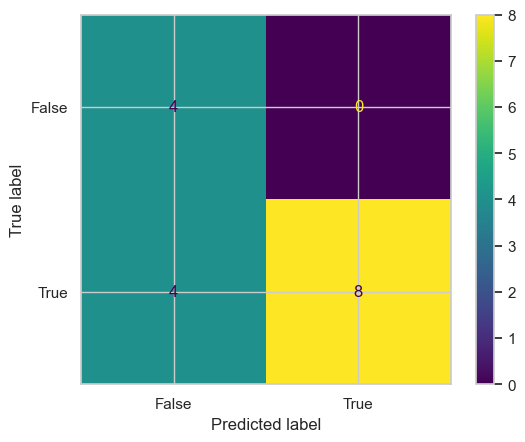

In [50]:
f1 = metrics.f1_score(df2['Y_b'], df2['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df2['Y_b'], df2['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df2['Y_b'], df2['Pred_qgeognn_b'])

print('qGeoGNN')
print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df2['Class_b'], df2['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], df2['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (0.5)
F1: 0.75
KAPPA: 0.0
AUC:1.0
ACC: 0.75

positive: 75%, negative: 25%


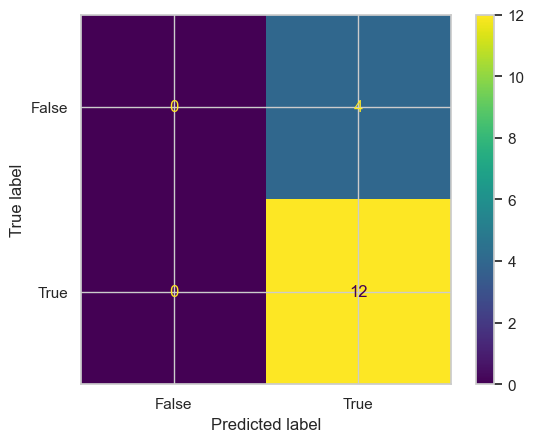

In [51]:
pred = np.array(df2.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)
    
f1 = metrics.f1_score(pred, df2['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Y_b'])
auc = metrics.roc_auc_score(df2['Y_b'], df2['Pred_b'])
acc = metrics.accuracy_score(pred, df2['Y_b'])

print('3DMolCSP (0.5)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df2['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.73)
F1: 0.875
KAPPA: 0.7142857142857143
AUC:1.0
ACC: 0.875

positive: 75%, negative: 25%


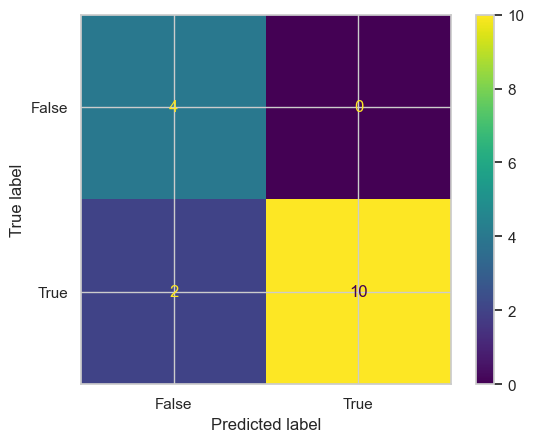

In [52]:
pred = np.array(df2.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.73, 1, 0)
    
f1 = metrics.f1_score(pred, df2['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Y_b'])
auc = metrics.roc_auc_score(df2['Y_b'], df2['Pred_b'])
acc = metrics.accuracy_score(pred, df2['Y_b'])

print('3DMolCSP (thr=0.73)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df2['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.9)
F1: 0.875
KAPPA: 0.7142857142857143
AUC:1.0
ACC: 0.875

positive: 75%, negative: 25%


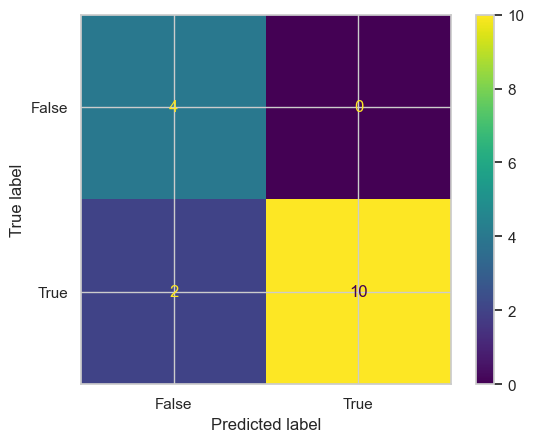

In [53]:
pred = np.array(df2.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)
    
f1 = metrics.f1_score(pred, df2['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Y_b'])
auc = metrics.roc_auc_score(df2['Y_b'], df2['Pred_b'])
acc = metrics.accuracy_score(pred, df2['Y_b'])

print('3DMolCSP (thr=0.9)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df2['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

All 

In [54]:
df_all = pd.concat([df1[['Y_b', 'Pred_qgeognn_b', 'Pred_b']],
                  df2[['Y_b', 'Pred_qgeognn_b', 'Pred_b']]])

In [55]:
len(df_all)

264

qGeoGNN
F1: 0.6287878787878788
KAPPA: 0.21808510638297873
ACC: 0.6287878787878788

positive: 66%, negative: 33%


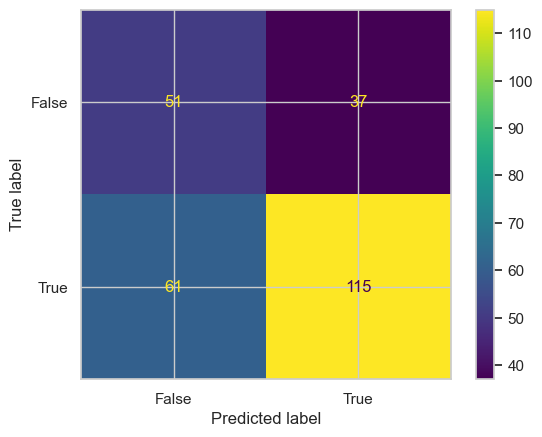

In [56]:
f1 = metrics.f1_score(df_all['Y_b'], df_all['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df_all['Y_b'], df_all['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df_all['Y_b'], df_all['Pred_qgeognn_b'])

print('qGeoGNN')
print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], df_all['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], df_all['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.5)
F1: 0.678030303030303
KAPPA: 0.19047619047619047
AUC:0.5888429752066116
ACC: 0.678030303030303

positive: 66%, negative: 33%


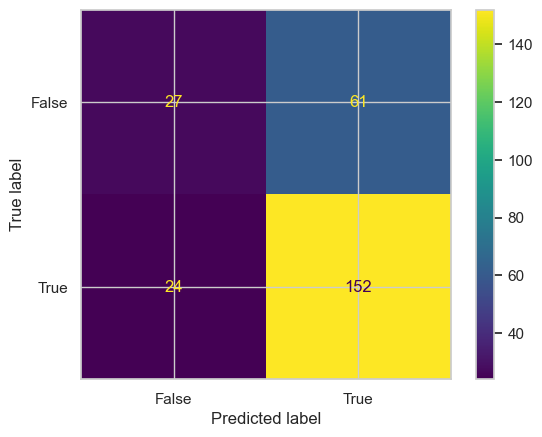

In [57]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)

f1 = metrics.f1_score(pred, df_all['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Y_b'])
auc = metrics.roc_auc_score(df_all['Y_b'], df_all['Pred_b'])
acc = metrics.accuracy_score(pred, df_all['Y_b'])

print('3DMolCSP (thr=0.5)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.73)
F1: 0.6856060606060606
KAPPA: 0.25671641791044775
AUC:0.5888429752066116
ACC: 0.6856060606060606

positive: 66%, negative: 33%


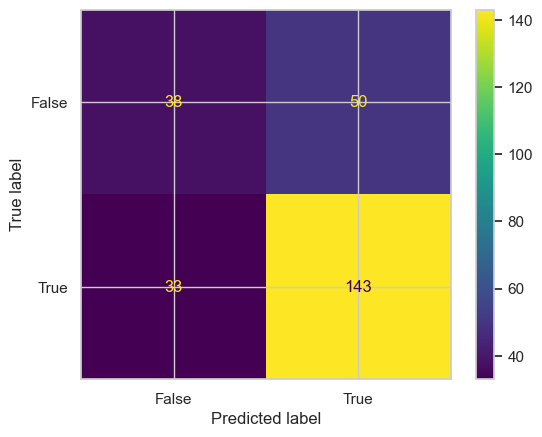

In [58]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.73, 1, 0)

f1 = metrics.f1_score(pred, df_all['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Y_b'])
auc = metrics.roc_auc_score(df_all['Y_b'], df_all['Pred_b'])
acc = metrics.accuracy_score(pred, df_all['Y_b'])

print('3DMolCSP (thr=0.73)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.9)
F1: 0.6931818181818182
KAPPA: 0.27893175074183973
AUC:0.5888429752066116
ACC: 0.6931818181818182

positive: 66%, negative: 33%


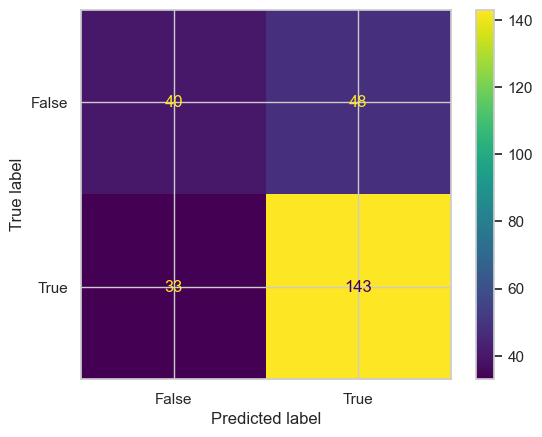

In [59]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)

f1 = metrics.f1_score(pred, df_all['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Y_b'])
auc = metrics.roc_auc_score(df_all['Y_b'], df_all['Pred_b'])
acc = metrics.accuracy_score(pred, df_all['Y_b'])

print('3DMolCSP (thr=0.9)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [60]:
# plot_roc_curve_b(pred, df_all['Class_b'].tolist())